In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import sys
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use("tableau-colorblind10")
plt.rcParams["font.size"] = 18

In [3]:
# Add model path to sys.path
path_to_model_directory = os.path.abspath("../model")
if path_to_model_directory not in sys.path:
    sys.path.append(path_to_model_directory)

# Now you can import your class
from PreTrainer import PreTrainer
from DownstreamTask import DownstreamClassificationTaskTrainer
from data import validate_data_format, ServeDataset, HitDataset
from TennisShotEmbedder import TennisShotEmbedder
from model_builder import build_tennis_embedder

In [35]:
# Configure the PreTrainer
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 50
train_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/train'
val_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/val'
test_path = '/home/florsanders/adl_ai_tennis_coach/data/tenniset/shot_labels/test'
model_config_file = '/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/model/configs/default.yaml'
model_weights_path = "/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/trained_models/best_model.pth"

## Check Serve and Hit Dataset

In [9]:
train_serve_dataset = ServeDataset(labels_path = train_path)

In [10]:
val_serve_dataset = ServeDataset(labels_path = val_path)

In [17]:
test_serve_dataset = ServeDataset(labels_path = test_path)

In [11]:
train_hit_dataset = HitDataset(labels_path = train_path)

In [12]:
val_hit_dataset = HitDataset(labels_path = val_path)

In [18]:
test_hit_dataset = HitDataset(labels_path = test_path)

Train Serve Dataset:
Pose3d Shape:  (81, 17, 3)
Position2d Shape:  (81, 2)
Number of PoseGraphs:  81
PoseGraph Shape:  [Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2

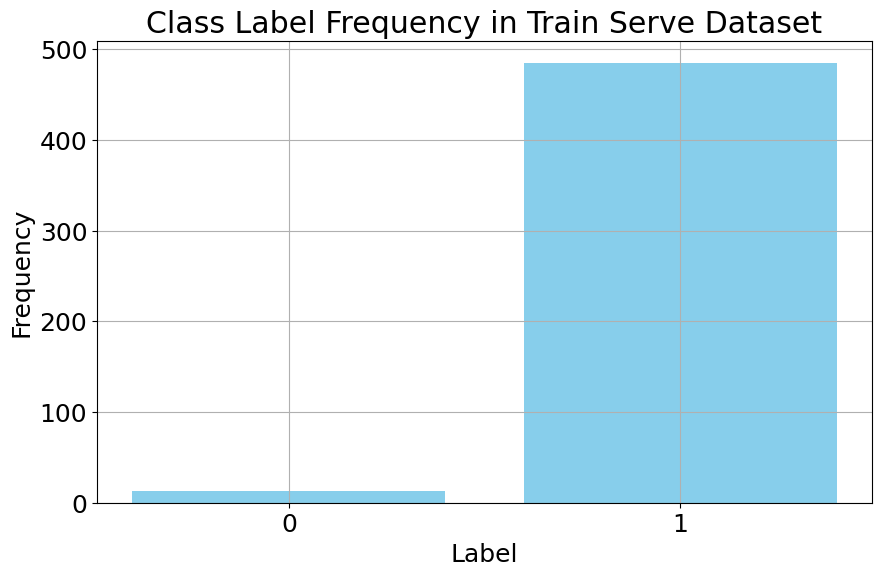

In [29]:
def get_data_info(dataset, dataset_name):
    pose3d_list = []
    position2d_list = []
    poseGraph_list = []
    label_list = []

    print(f"{dataset_name}:")

    counter = 0
    for pose3d, position2d, poseGraph, label in dataset:
        if counter == 0:
            print("Pose3d Shape: ", pose3d.shape)
            print("Position2d Shape: ", position2d[0].shape)
            print("Number of PoseGraphs: ", len(poseGraph))
            print("PoseGraph Shape: ", poseGraph)
            print("Label: ", label)
            counter += 1
        pose3d_list.append(pose3d)
        position2d_list.append(position2d)
        poseGraph_list.append(poseGraph)
        label_list.append(label)
    
    if len(pose3d_list) == len(position2d_list) == len(poseGraph_list) == len(label_list):
        print("Number of Samples: ", len(pose3d_list))
    else:
        print("Number of Samples Do Not Match")
    
    unique_labels = np.unique(label_list)
    labels, counts = np.unique(label_list, return_counts=True)
    print("Number of Unique Labels: ", len(labels))
    print("Unique Labels and their counts:")
    for label, count in zip(labels, counts):
        print(f"Label {label}: {count}")
    
    # Plotting the histogram of label frequencies
    plt.figure(figsize=(10, 6))
    plt.bar(labels.astype(int), counts, color='skyblue')  # Cast labels to int for display
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title(f'Class Label Frequency in {dataset_name}')
    plt.xticks(labels.astype(int), labels.astype(int))  # Ensure x-ticks are integer values of labels
    plt.grid(True)
    plt.show()



get_data_info(train_serve_dataset, "Train Serve Dataset")

Val Serve Dataset:
Pose3d Shape:  (83, 17, 3)
Position2d Shape:  (83, 2)
Number of PoseGraphs:  83
PoseGraph Shape:  [Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 

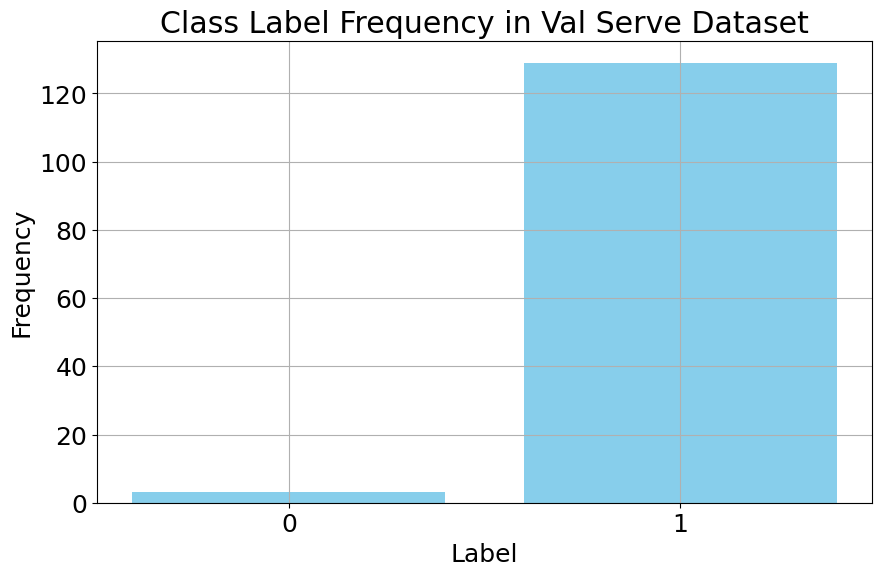

In [30]:
get_data_info(val_serve_dataset, "Val Serve Dataset")

Test Serve Dataset:
Pose3d Shape:  (77, 17, 3)
Position2d Shape:  (77, 2)
Number of PoseGraphs:  77
PoseGraph Shape:  [Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2,

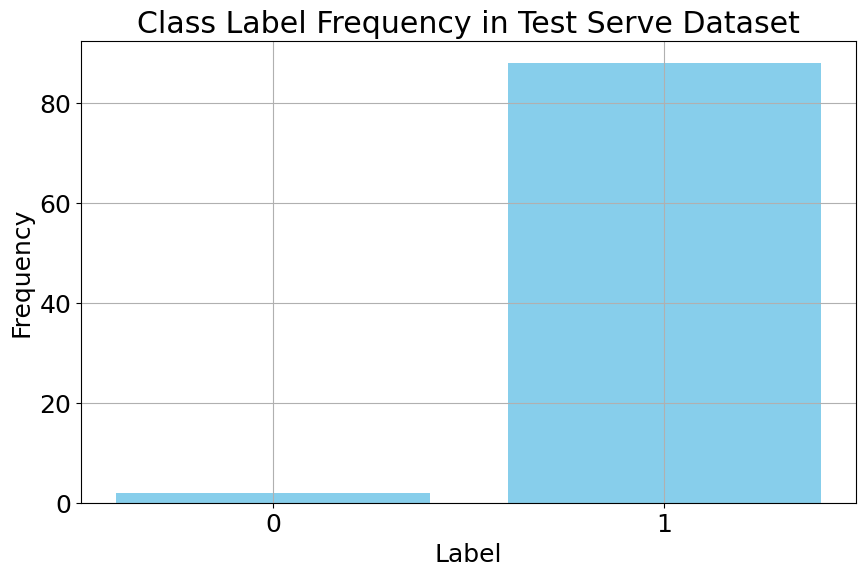

In [31]:
get_data_info(test_serve_dataset, "Test Serve Dataset")

Train Hit Dataset:
Pose3d Shape:  (20, 17, 3)
Position2d Shape:  (20, 2)
Number of PoseGraphs:  20
PoseGraph Shape:  [Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38])]
Label:  8
Number of Samples:  1717
Number of Unique Labels:  11
Unique Labels and their counts:
Label 0: 11
Label 1: 269
Label 2: 555
Label 3:

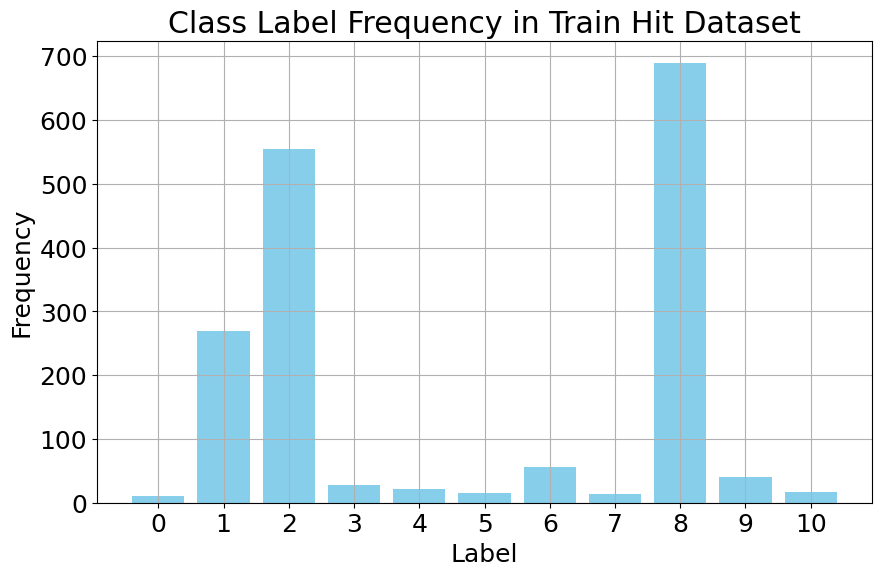

In [32]:
get_data_info(train_hit_dataset, "Train Hit Dataset")

Val Hit Dataset:
Pose3d Shape:  (19, 17, 3)
Position2d Shape:  (19, 2)
Number of PoseGraphs:  19
PoseGraph Shape:  [Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38])]
Label:  2
Number of Samples:  427
Number of Unique Labels:  11
Unique Labels and their counts:
Label 0: 8
Label 1: 64
Label 2: 130
Label 3: 7
Label 4: 13
Label 5: 5
Label 6: 10
Labe

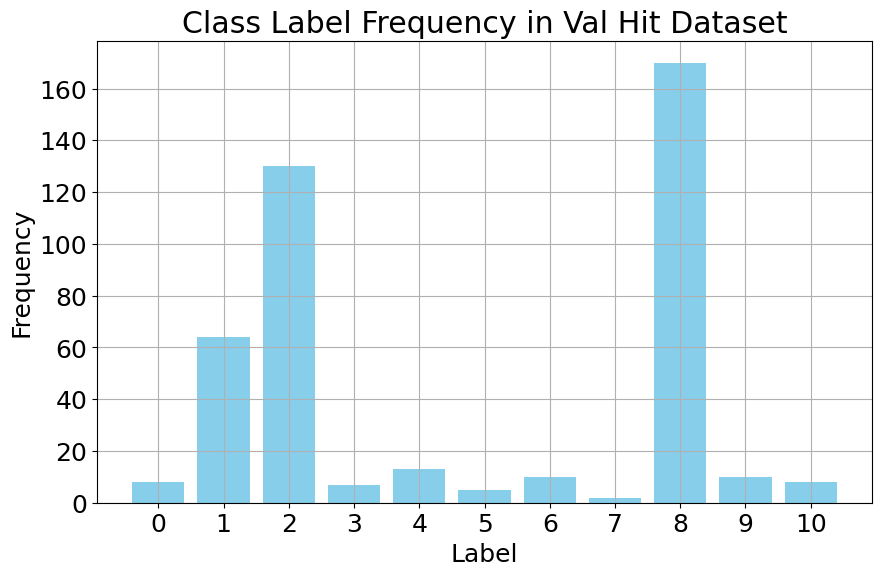

In [33]:
get_data_info(val_hit_dataset, "Val Hit Dataset")

Test Hit Dataset:
Pose3d Shape:  (24, 17, 3)
Position2d Shape:  (24, 2)
Number of PoseGraphs:  24
PoseGraph Shape:  [Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 38]), Data(x=[17, 3], edge_index=[2, 3

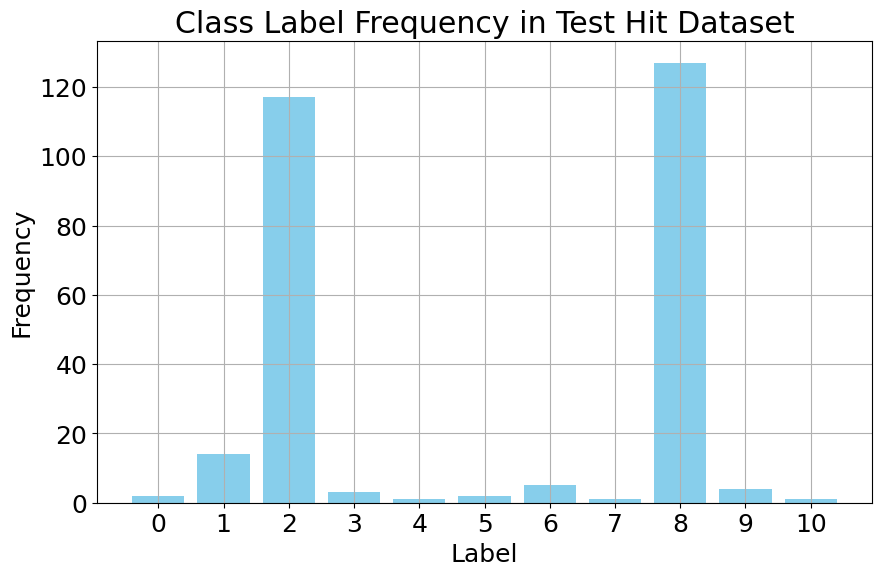

In [34]:
get_data_info(test_hit_dataset, "Test Hit Dataset")

## Test Pretrained Model

In [5]:
# Trainer Setup
trainer = PreTrainer(
    batch_size=BATCH_SIZE,
    lr=LR,
    epochs=EPOCHS,
    train_path=train_path,
    val_path=val_path,
    model_config_path=model_config_file,
    model_save_path='trained_models'
)

Using device: cuda


In [6]:
trainer.load_pretrained_model(model_weights_path)

Model loaded from /home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/trained_models/best_model.pth


Test Loss: 0.03309369382138053


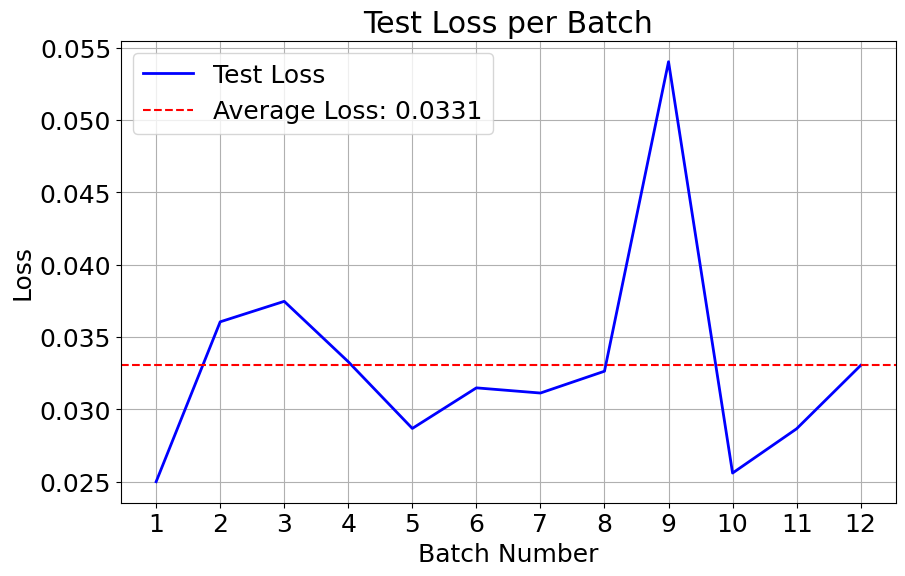

In [7]:
trainer.test_trained_model(test_path)

## Train for Serve and Hit Classification Downstream Task 

#### Train and Evaluate for Serve Classification

In [36]:
serve_downstream_model = DownstreamClassificationTaskTrainer(model_config_path=model_config_file,
                                                             model_weights_path=model_weights_path, 
                                                             train_path=train_path, 
                                                             val_path=val_path, 
                                                             test_path=test_path, 
                                                             model_save_path='downstream_trained_models', 
                                                             batch_size=BATCH_SIZE, 
                                                             lr=LR, 
                                                             epochs=EPOCHS, 
                                                             task = 'serve')

Using device: cuda


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:04<00:00,  3.60it/s]


Epoch 1, Loss: 0.12005639146082103
Validation Loss: 0.09507833682000637, Validation Accuracy: 97.70992366412214


100%|██████████| 16/16 [00:04<00:00,  3.63it/s]


Epoch 2, Loss: 0.119699043687433
Validation Loss: 0.09327398687601089, Validation Accuracy: 97.70992366412214


100%|██████████| 16/16 [00:04<00:00,  3.80it/s]


Epoch 3, Loss: 0.12536100298166275
Validation Loss: 0.09396300166845321, Validation Accuracy: 97.70992366412214


100%|██████████| 16/16 [00:04<00:00,  3.79it/s]


Epoch 4, Loss: 0.1247189404675737
Validation Loss: 0.09505729340016841, Validation Accuracy: 97.70992366412214


100%|██████████| 16/16 [00:04<00:00,  3.76it/s]


Epoch 5, Loss: 0.12484278262127191
Validation Loss: 0.09578288681805133, Validation Accuracy: 97.70992366412214
Test Loss: 0.10261822491884232, Test Accuracy: 97.77777777777777


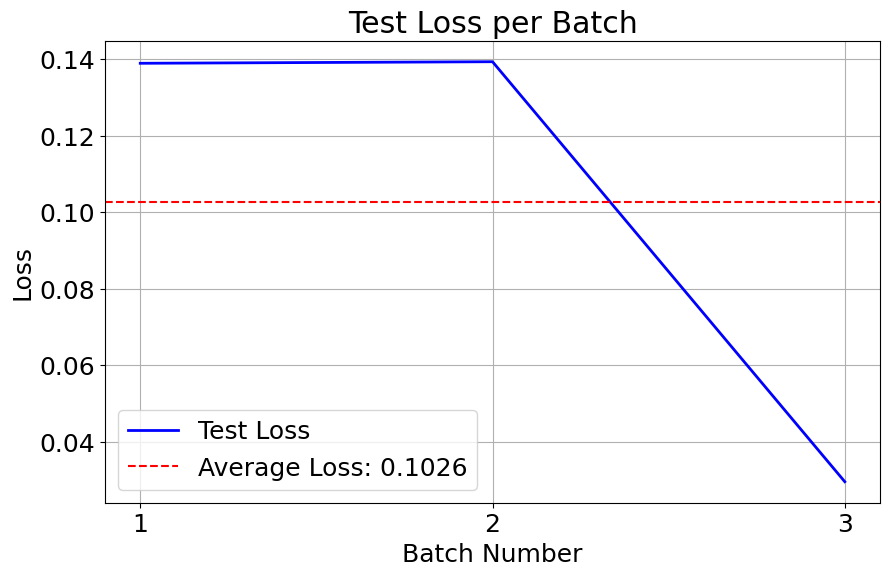

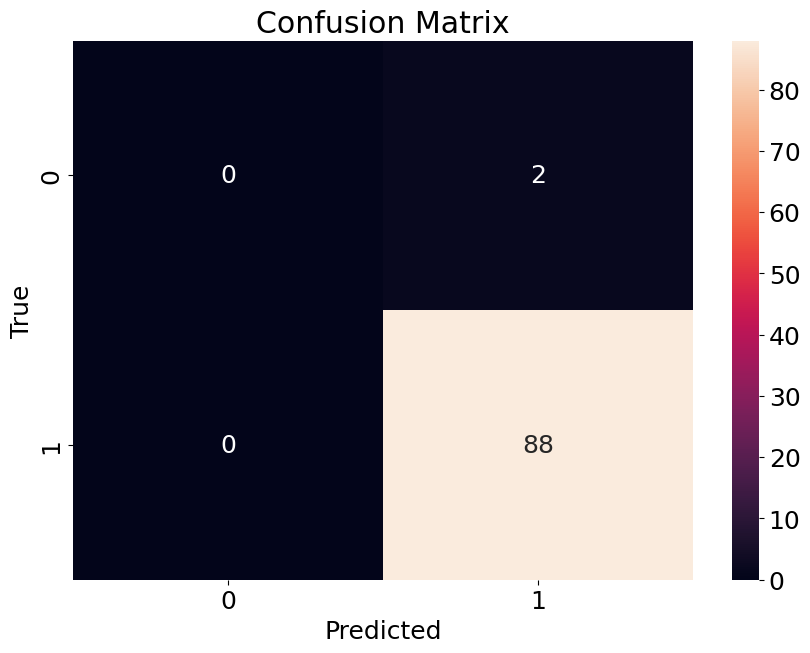

In [23]:
train_loss_history, val_loss_history, test_loss_history = serve_downstream_model.train()

In [ ]:
serve_model_path = "/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/serve_downstream_trained_models/best_model.pth"
serve_downstream_model.load_model(serve_model_path)

In [ ]:
serve_downstream_model.test_trained_model(test_path, save_path = False)

#### Train and Evaluate for Hit Classification

In [37]:
hit_downstream_model = DownstreamClassificationTaskTrainer(model_config_path=model_config_file,
                                                             model_weights_path=model_weights_path, 
                                                             train_path=train_path, 
                                                             val_path=val_path, 
                                                             test_path=test_path, 
                                                             model_save_path='downstream_trained_models', 
                                                             batch_size=BATCH_SIZE, 
                                                             lr=LR, 
                                                             epochs=EPOCHS, 
                                                             task = 'hit')

Using device: cuda


  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:12<00:00,  4.49it/s]


Epoch 1, Loss: 1.5735977866031505
Validation Loss: 1.5693782312529427, Validation Accuracy: 45.433255269320846
Saving model at hit_downstream_trained_models with validation loss of 1.5693782312529427


100%|██████████| 54/54 [00:13<00:00,  4.09it/s]


Epoch 2, Loss: 1.4775029840292755
Validation Loss: 1.5230698415211268, Validation Accuracy: 40.04683840749414
Saving model at hit_downstream_trained_models with validation loss of 1.5230698415211268


100%|██████████| 54/54 [00:12<00:00,  4.26it/s]


Epoch 3, Loss: 1.4746478133731418
Validation Loss: 1.4886624813079834, Validation Accuracy: 39.81264637002342
Saving model at hit_downstream_trained_models with validation loss of 1.4886624813079834


100%|██████████| 54/54 [00:12<00:00,  4.28it/s]


Epoch 4, Loss: 1.4403278275772378
Validation Loss: 1.4395170424665724, Validation Accuracy: 46.13583138173302
Saving model at hit_downstream_trained_models with validation loss of 1.4395170424665724


100%|██████████| 54/54 [00:12<00:00,  4.26it/s]


Epoch 5, Loss: 1.3846445503058258
Validation Loss: 1.4349968688828605, Validation Accuracy: 48.711943793911004
Saving model at hit_downstream_trained_models with validation loss of 1.4349968688828605


100%|██████████| 54/54 [00:12<00:00,  4.29it/s]


Epoch 6, Loss: 1.3525881038771734
Validation Loss: 1.3900296304907118, Validation Accuracy: 51.99063231850117
Saving model at hit_downstream_trained_models with validation loss of 1.3900296304907118


100%|██████████| 54/54 [00:12<00:00,  4.45it/s]


Epoch 7, Loss: 1.2873640590243869
Validation Loss: 1.4234223748956407, Validation Accuracy: 49.414519906323186


100%|██████████| 54/54 [00:13<00:00,  4.13it/s]


Epoch 8, Loss: 1.2996520190327256
Validation Loss: 1.3710566035338811, Validation Accuracy: 51.522248243559716
Saving model at hit_downstream_trained_models with validation loss of 1.3710566035338811


100%|██████████| 54/54 [00:12<00:00,  4.47it/s]


Epoch 9, Loss: 1.2453130240793582
Validation Loss: 1.2853833053793227, Validation Accuracy: 55.50351288056206
Saving model at hit_downstream_trained_models with validation loss of 1.2853833053793227


100%|██████████| 54/54 [00:11<00:00,  4.52it/s]


Epoch 10, Loss: 1.1854492436956476
Validation Loss: 1.2775918926511491, Validation Accuracy: 54.80093676814988
Saving model at hit_downstream_trained_models with validation loss of 1.2775918926511491


100%|██████████| 54/54 [00:12<00:00,  4.48it/s]


Epoch 11, Loss: 1.1987532653190471
Validation Loss: 1.2557475098541804, Validation Accuracy: 55.50351288056206
Saving model at hit_downstream_trained_models with validation loss of 1.2557475098541804


100%|██████████| 54/54 [00:12<00:00,  4.46it/s]


Epoch 12, Loss: 1.1859328172825
Validation Loss: 1.2533852798598153, Validation Accuracy: 56.20608899297424
Saving model at hit_downstream_trained_models with validation loss of 1.2533852798598153


100%|██████████| 54/54 [00:12<00:00,  4.42it/s]


Epoch 13, Loss: 1.1551071438524458
Validation Loss: 1.2602984351771218, Validation Accuracy: 56.67447306791569


100%|██████████| 54/54 [00:13<00:00,  4.13it/s]


Epoch 14, Loss: 1.1422618782078777
Validation Loss: 1.1966790514332908, Validation Accuracy: 59.4847775175644
Saving model at hit_downstream_trained_models with validation loss of 1.1966790514332908


100%|██████████| 54/54 [00:11<00:00,  4.56it/s]


Epoch 15, Loss: 1.1195582526701469
Validation Loss: 1.2443566960947854, Validation Accuracy: 58.5480093676815


100%|██████████| 54/54 [00:12<00:00,  4.29it/s]


Epoch 16, Loss: 1.1761911952937092
Validation Loss: 1.2245138841015952, Validation Accuracy: 57.142857142857146


100%|██████████| 54/54 [00:11<00:00,  4.53it/s]


Epoch 17, Loss: 1.093715622469231
Validation Loss: 1.1716990854058946, Validation Accuracy: 57.142857142857146
Saving model at hit_downstream_trained_models with validation loss of 1.1716990854058946


100%|██████████| 54/54 [00:11<00:00,  4.51it/s]


Epoch 18, Loss: 1.0729001186512135
Validation Loss: 1.133392150912966, Validation Accuracy: 60.421545667447305
Saving model at hit_downstream_trained_models with validation loss of 1.133392150912966


100%|██████████| 54/54 [00:11<00:00,  4.58it/s]


Epoch 19, Loss: 1.0514573300326313
Validation Loss: 1.1852866624082838, Validation Accuracy: 57.84543325526932


100%|██████████| 54/54 [00:12<00:00,  4.31it/s]


Epoch 20, Loss: 1.046716524495019
Validation Loss: 1.1240650628294264, Validation Accuracy: 61.35831381733021
Saving model at hit_downstream_trained_models with validation loss of 1.1240650628294264


100%|██████████| 54/54 [00:11<00:00,  4.64it/s]


Epoch 21, Loss: 1.0204923020468817
Validation Loss: 1.1599771976470947, Validation Accuracy: 59.95316159250586


100%|██████████| 54/54 [00:12<00:00,  4.50it/s]


Epoch 22, Loss: 1.023833194816554
Validation Loss: 1.1462072942938124, Validation Accuracy: 60.88992974238876


100%|██████████| 54/54 [00:12<00:00,  4.48it/s]


Epoch 23, Loss: 0.9786080883608924
Validation Loss: 1.1011317840644292, Validation Accuracy: 61.59250585480094
Saving model at hit_downstream_trained_models with validation loss of 1.1011317840644292


100%|██████████| 54/54 [00:11<00:00,  4.57it/s]


Epoch 24, Loss: 0.9897981650299497
Validation Loss: 1.1105443111487798, Validation Accuracy: 60.421545667447305


100%|██████████| 54/54 [00:12<00:00,  4.46it/s]


Epoch 25, Loss: 0.9865529470973544
Validation Loss: 1.1968683174678258, Validation Accuracy: 55.269320843091336


100%|██████████| 54/54 [00:11<00:00,  4.65it/s]


Epoch 26, Loss: 0.9705260616761667
Validation Loss: 1.1369592121669225, Validation Accuracy: 59.95316159250586


100%|██████████| 54/54 [00:11<00:00,  4.63it/s]


Epoch 27, Loss: 0.9551934445345843
Validation Loss: 1.123821062701089, Validation Accuracy: 61.124121779859486


100%|██████████| 54/54 [00:12<00:00,  4.47it/s]


Epoch 28, Loss: 0.9385365424332796
Validation Loss: 1.1684917679854803, Validation Accuracy: 57.61124121779859


100%|██████████| 54/54 [00:12<00:00,  4.40it/s]


Epoch 29, Loss: 0.9828329472630112
Validation Loss: 1.185649614248957, Validation Accuracy: 57.84543325526932


100%|██████████| 54/54 [00:12<00:00,  4.45it/s]


Epoch 30, Loss: 0.9326472878456116
Validation Loss: 1.1153828416551863, Validation Accuracy: 60.421545667447305


100%|██████████| 54/54 [00:11<00:00,  4.51it/s]


Epoch 31, Loss: 0.9195974932776557
Validation Loss: 1.277764739734786, Validation Accuracy: 55.03512880562061


100%|██████████| 54/54 [00:11<00:00,  4.53it/s]


Epoch 32, Loss: 0.9264126232376805
Validation Loss: 1.1046378697667802, Validation Accuracy: 62.06088992974239


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Epoch 33, Loss: 0.8658211678266525
Validation Loss: 1.122920498251915, Validation Accuracy: 61.124121779859486


100%|██████████| 54/54 [00:12<00:00,  4.45it/s]


Epoch 34, Loss: 0.8881165854356907
Validation Loss: 1.1270814452852522, Validation Accuracy: 62.06088992974239


100%|██████████| 54/54 [00:12<00:00,  4.48it/s]


Epoch 35, Loss: 0.8630416724416945
Validation Loss: 1.1531526701790946, Validation Accuracy: 61.35831381733021


100%|██████████| 54/54 [00:13<00:00,  4.15it/s]


Epoch 36, Loss: 0.8452883727020688
Validation Loss: 1.1894725731440954, Validation Accuracy: 59.01639344262295


100%|██████████| 54/54 [00:12<00:00,  4.20it/s]


Epoch 37, Loss: 0.8383120436359335
Validation Loss: 1.134505889245442, Validation Accuracy: 61.59250585480094


100%|██████████| 54/54 [00:12<00:00,  4.21it/s]


Epoch 38, Loss: 0.8293078387225116
Validation Loss: 1.135729342699051, Validation Accuracy: 62.76346604215457


100%|██████████| 54/54 [00:12<00:00,  4.39it/s]


Epoch 39, Loss: 0.8153905393900694
Validation Loss: 1.3021630346775055, Validation Accuracy: 55.269320843091336


100%|██████████| 54/54 [00:12<00:00,  4.23it/s]


Epoch 40, Loss: 0.7963095003807986
Validation Loss: 1.1614858508110046, Validation Accuracy: 60.88992974238876


100%|██████████| 54/54 [00:13<00:00,  4.13it/s]


Epoch 41, Loss: 0.7984061036948804
Validation Loss: 1.1547431179455347, Validation Accuracy: 62.06088992974239


100%|██████████| 54/54 [00:12<00:00,  4.36it/s]


Epoch 42, Loss: 0.7847926947805617
Validation Loss: 1.1621565563338143, Validation Accuracy: 62.997658079625296


100%|██████████| 54/54 [00:13<00:00,  3.99it/s]


Epoch 43, Loss: 0.7765306995974647
Validation Loss: 1.1459202212946755, Validation Accuracy: 64.63700234192038


100%|██████████| 54/54 [00:12<00:00,  4.26it/s]


Epoch 44, Loss: 0.7269746043063976
Validation Loss: 1.2207567606653487, Validation Accuracy: 60.88992974238876


100%|██████████| 54/54 [00:12<00:00,  4.26it/s]


Epoch 45, Loss: 0.7514628309894491
Validation Loss: 1.2081067221505302, Validation Accuracy: 60.421545667447305


100%|██████████| 54/54 [00:11<00:00,  4.56it/s]


Epoch 46, Loss: 0.7304679304361343
Validation Loss: 1.2581328196184975, Validation Accuracy: 61.35831381733021


100%|██████████| 54/54 [00:12<00:00,  4.30it/s]


Epoch 47, Loss: 0.7241672967319135
Validation Loss: 1.2561175567763192, Validation Accuracy: 61.82669789227166


100%|██████████| 54/54 [00:12<00:00,  4.31it/s]


Epoch 48, Loss: 0.6809831482392771
Validation Loss: 1.176107474735805, Validation Accuracy: 62.997658079625296


100%|██████████| 54/54 [00:12<00:00,  4.22it/s]


Epoch 49, Loss: 0.6817644978011096
Validation Loss: 1.219389225755419, Validation Accuracy: 62.997658079625296


100%|██████████| 54/54 [00:12<00:00,  4.19it/s]


Epoch 50, Loss: 0.6488435505716889
Validation Loss: 1.2553215537752425, Validation Accuracy: 62.295081967213115
Test Loss: 1.0231219331423442, Test Accuracy: 70.03610108303249


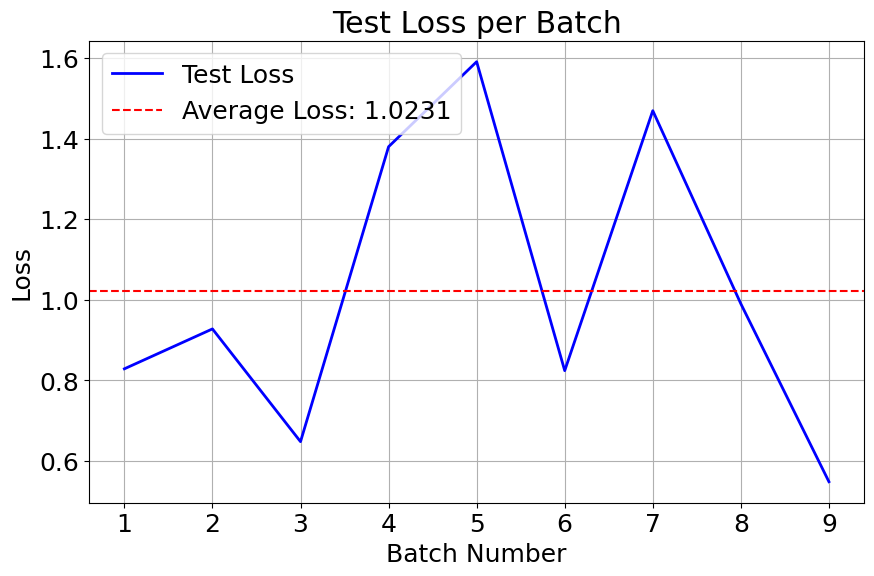

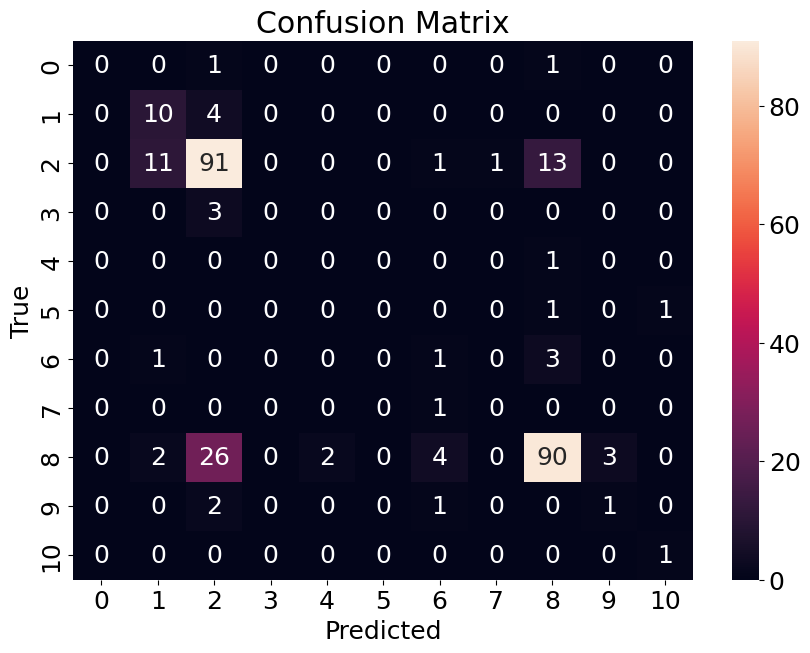

In [38]:
train_loss_history, val_loss_history, test_loss_history = hit_downstream_model.train()

In [39]:
hit_model_path = "/home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/hit_downstream_trained_models/best_model.pth"
hit_downstream_model.load_model(hit_model_path)

Model loaded from /home/tawab/e6691-2024spring-project-TECO-as7092-gyt2107-fps2116/src/train/hit_downstream_trained_models/best_model.pth


Test Loss: 0.928749680519104, Test Accuracy: 71.11913357400722


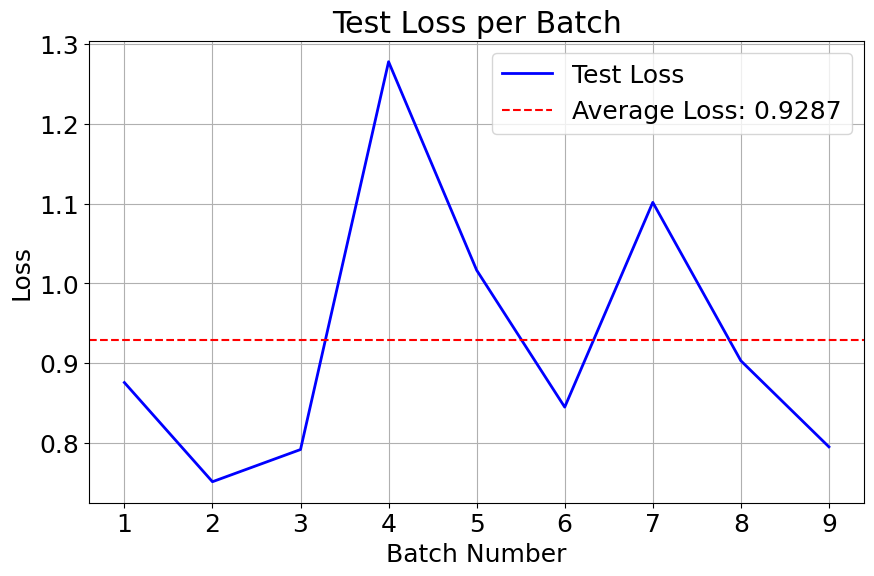

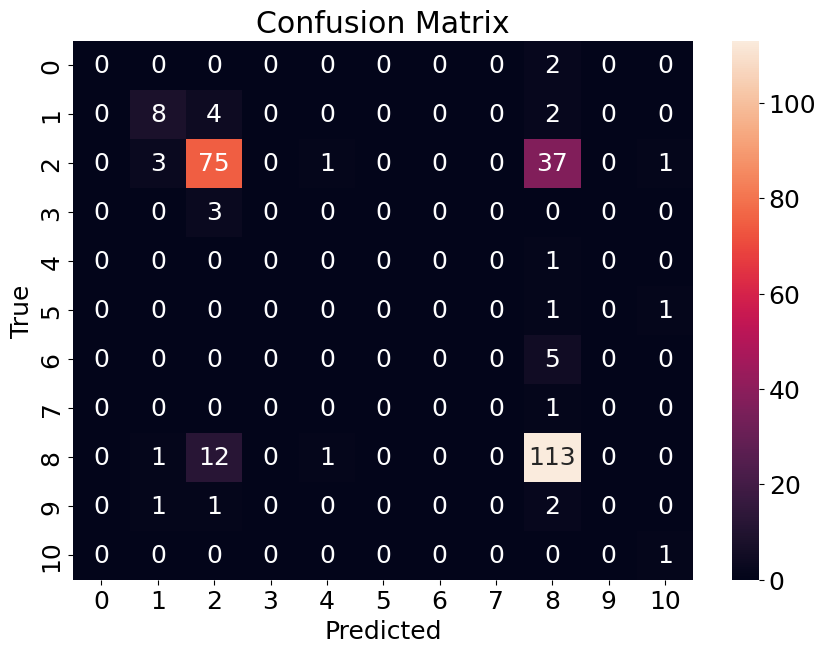

In [40]:
hit_downstream_model.test_trained_model(test_path, save_path = False)